In [22]:
#!pip3 install -U irbasis3 xprec

In [23]:
#!pip3 install jaxlib jax

In [24]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    'text.latex.preamble': r"\usepackage{amsmath}"
})

import irbasis3
from numpy.polynomial.legendre import leggauss

In [25]:
from jax.config import config
config.update("jax_enable_x64", True)
import jax
from jax import numpy as jnp
from jax import grad, jit, vmap

In [26]:
def scale_quad(x, w, xmax, xmin):
    """ Scale weights and notes of quadrature to the interval [xmin, xmax] """
    assert xmin < xmax
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x + 1) + xmin
    return x_, w_

def _test_scale_quad():
    """ Integrate x^3 over [3, 0] """
    xmax = 3
    x_, w_ = leggauss(10)
    x, w = scale_quad(x_, w_, xmax, 0)
    f = lambda x: x**3
    res = np.sum(w * f(x))
    ref = 0.25*(xmax**4)
    assert np.abs(res - ref) < 1e-10

_test_scale_quad()

In [27]:
gtau_ = np.loadtxt("Gtau.in")
taus = gtau_[:,0]
gtau = gtau_[:,1]

In [28]:
dos_ = np.loadtxt("Gtau.in.dos")
omegas = dos_[:,0]
dos = dos_[:,1]

import scipy
from scipy.interpolate import interp1d
rho = interp1d(omegas, dos, fill_value=(0,0), bounds_error=False)
print(scipy.__version__)
print(rho(100))

1.7.3
0.0


In [29]:
beta = 100.0
wmax = np.amax(np.abs(omegas)) * 2
print("wmax", wmax)
print("beta", beta)
lambda_ = wmax * beta
K = irbasis3.KernelFFlat(lambda_=lambda_)
basis = irbasis3.FiniteTempBasis(
    K, statistics='F', beta=beta, eps=1e-15)
print("dim", basis.size)
basis.s/basis.s[0]

wmax 8.0
beta 100.0
dim 68


array([1.00000000e+00, 9.16847626e-01, 6.72789028e-01, 5.32063079e-01,
       3.74750213e-01, 2.71244943e-01, 1.88071606e-01, 1.30556635e-01,
       8.90362703e-02, 6.03464930e-02, 4.04843415e-02, 2.69633621e-02,
       1.78186816e-02, 1.16946959e-02, 7.62387402e-03, 4.93866227e-03,
       3.17970019e-03, 2.03523080e-03, 1.29531923e-03, 8.19889907e-04,
       5.16202256e-04, 3.23321005e-04, 2.01490947e-04, 1.24950446e-04,
       7.71133187e-05, 4.73669219e-05, 2.89612045e-05, 1.76275635e-05,
       1.06816423e-05, 6.44447183e-06, 3.87143090e-06, 2.31590090e-06,
       1.37962270e-06, 8.18499875e-07, 4.83636846e-07, 2.84633381e-07,
       1.66855275e-07, 9.74322075e-08, 5.66752462e-08, 3.28421337e-08,
       1.89598235e-08, 1.09048387e-08, 6.24888466e-09, 3.56779273e-09,
       2.02966996e-09, 1.15051993e-09, 6.49859383e-10, 3.65775164e-10,
       2.05159258e-10, 1.14673251e-10, 6.38761548e-11, 3.54594615e-11,
       1.96179177e-11, 1.08171125e-11, 5.94452763e-12, 3.25597036e-12,
      

In [30]:
dim = basis.size
u = basis.u
v = basis.v
svals = basis.s

In [31]:
roots = v[-1].roots()
smpl_points = np.hstack((-wmax, roots, wmax))
nsp = smpl_points.size
smpl_points

array([-8.        , -7.95197133, -7.75222533, -7.41314435, -6.96474427,
       -6.44200351, -5.87915276, -5.30568771, -4.74443142, -4.21129288,
       -3.71607999, -3.26376869, -2.85581858, -2.49131889, -2.16788848,
       -1.88233316, -1.63109871, -1.41056721, -1.2172403 , -1.04784477,
       -0.89938695, -0.76917474, -0.65481989, -0.5542288 , -0.46558671,
       -0.38733832, -0.31816674, -0.25697241, -0.2028539 , -0.15509354,
       -0.11315368, -0.07670247, -0.0457235 , -0.02052408,  0.        ,
        0.02052408,  0.0457235 ,  0.07670247,  0.11315368,  0.15509354,
        0.2028539 ,  0.25697241,  0.31816674,  0.38733832,  0.46558671,
        0.5542288 ,  0.65481989,  0.76917474,  0.89938695,  1.04784477,
        1.2172403 ,  1.41056721,  1.63109871,  1.88233316,  2.16788848,
        2.49131889,  2.85581858,  3.26376869,  3.71607999,  4.21129288,
        4.74443142,  5.30568771,  5.87915276,  6.44200351,  6.96474427,
        7.41314435,  7.75222533,  7.95197133,  8.        ])

In [32]:
# Projector from sampled values to \int dw rho(w)
prj_sum_rule = np.zeros(nsp)
for s in range(nsp-1):
    tmp = 0.5 * (smpl_points[s+1] - smpl_points[s])
    prj_sum_rule[s] += tmp
    prj_sum_rule[s+1] += tmp

In [33]:
# Projector from sampled values to rho_l
prj = np.zeros((svals.size, nsp))

x_, w_ = leggauss(10)

for s in range(nsp-1):
    x, w = scale_quad(x_, w_, smpl_points[s+1], smpl_points[s])
    dx = smpl_points[s+1] - smpl_points[s]
    f = (x - smpl_points[s])/dx
    g = ( smpl_points[s+1] - x)/dx
    print(x)
    for l in range(svals.size):
        prj[l, s+1] += np.sum(w * v[l](x) * f)
        prj[l, s] += np.sum(w * v[l](x) * g)

print("cond: ", np.linalg.cond(prj))

[-7.99937338 -7.99675959 -7.99230123 -7.98639337 -7.97956078 -7.97241055
 -7.96557796 -7.9596701  -7.95521175 -7.95259795]
[-7.9493653  -7.93849481 -7.919953   -7.89538283 -7.86696686 -7.83722981
 -7.80881383 -7.78424366 -7.76570186 -7.75483137]
[-7.74780143 -7.72934811 -7.69787227 -7.65616291 -7.60792507 -7.55744461
 -7.50920677 -7.46749741 -7.43602157 -7.41756825]
[-7.40729419 -7.38289155 -7.34126796 -7.28611157 -7.22232194 -7.15556667
 -7.09177704 -7.03662066 -6.99499707 -6.97059443]
[-6.95792421 -6.92947583 -6.88095142 -6.81665061 -6.74228523 -6.66446254
 -6.59009717 -6.52579635 -6.47727195 -6.44882357]
[-6.43466014 -6.40402891 -6.35178122 -6.28254659 -6.20247515 -6.11868111
 -6.03860967 -5.96937504 -5.91712735 -5.88649612]
[-5.87167091 -5.84046203 -5.78722905 -5.71668879 -5.63510735 -5.54973312
 -5.46815168 -5.39761141 -5.34437843 -5.31316956]
[-5.29836515 -5.26782069 -5.21572101 -5.14668251 -5.06683789 -4.98328124
 -4.90343662 -4.83439812 -4.78229844 -4.75175398]
[-4.7374757  -4.

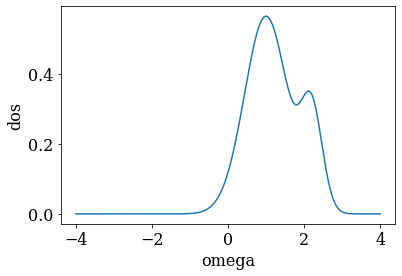

In [34]:
plt.xlabel("omega")
plt.ylabel("dos")
plt.plot(omegas, dos)

[-7.99999977 -7.99999878 -7.999997   ...  7.999997    7.99999878
  7.99999977]


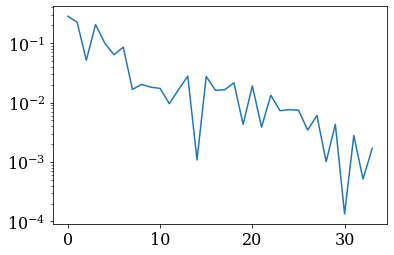

In [35]:
# Expand the spectral function in IR
x_, w_ = leggauss(10000)
x, w = scale_quad(x_, w_, wmax, -wmax)
all_l = np.arange(svals.size)

print(x)
rhol = np.einsum('lw,w,w->l', v.value(all_l[:,None], x[None,:]), w, rho(x), optimize=True)

plt.semilogy(np.abs(rhol)[::2])

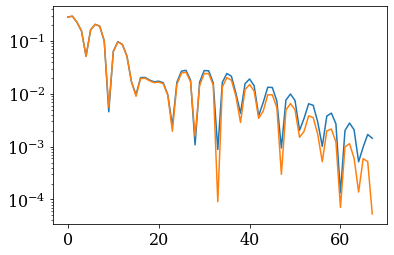

In [36]:
# Compute rho_l using projector
rhol2 = prj @ rho(smpl_points)

plt.semilogy(np.abs(rhol))
plt.semilogy(np.abs(rhol2))

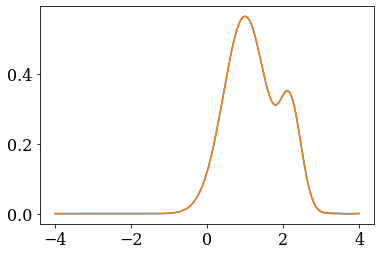

In [37]:
rho_reconst = np.einsum('lw,l->w', v.value(all_l[:,None], omegas[None,:]), rhol)

plt.plot(omegas, rho_reconst)
plt.plot(omegas, rho(omegas))

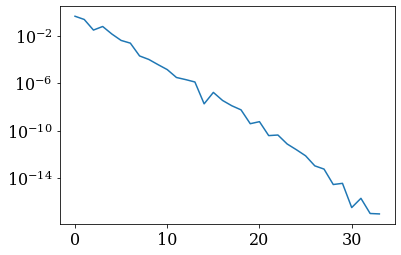

In [38]:
gl = - svals * rhol
plt.semilogy(np.abs(gl)[::2])

$$
\frac{1}{2} \sum_l |g_l + S_l \rho_l|^2 + \lambda \sum_l |\rho_l|
$$

In [49]:
from scipy.optimize import minimize

reg = 1e-8

def _cost2(gl, b_omega, reg):
    rho_omega = b_omega**2
    rhol = prj @ rho_omega
    return 0.5 * jnp.linalg.norm(gl + svals*rhol)**2 + reg * jnp.sum(jnp.abs(rhol))

loss2 = lambda x: _cost2(gl, x, reg)
grad_loss2 = jit(grad(loss2))

In [50]:
r = minimize(loss2, np.sqrt(rho(smpl_points)), method='BFGS', jac=grad_loss2, tol=1e-10, options={'gtol': 1e-10})

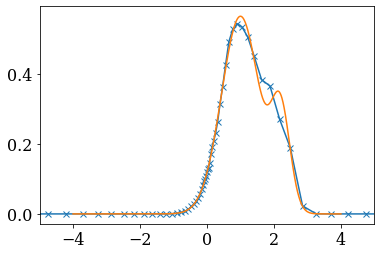

In [54]:
plt.xlim([-5, 5])
plt.plot(smpl_points, r.x**2, marker='x')
plt.plot(omegas, rho(omegas))

18.41470589709876


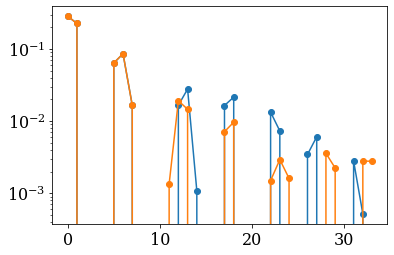

In [52]:
rhol_spm2 = prj @ (r.x**2)
print(prj_sum_rule @ np.exp(r.x))
plt.semilogy(rhol[::2], marker='o')
plt.semilogy(rhol_spm2[::2], marker='o')